# Methods for Data Science: Course Work 2

In [1]:
import pandas as pd
from pandas.core.frame import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.sparse import linalg
from scipy.optimize import nnls
from scipy.stats import multivariate_normal 

## Task 1: Neural Networks, Dimensionality Reduction and Mixture Models (65 marks)

In [2]:
def standardise(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

In [3]:
def normalize(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

In [4]:
def normalize_nmf(X):
    X_norm = (X- np.min(X)) / (np.max(X) - np.min(X))
    return X_norm

In [5]:
train = pd.read_csv("MNIST_train.csv")
test = pd.read_csv("MNIST_test.csv")

In [6]:
train_norm = normalize(train.to_numpy())
train_norm_nmf = normalize_nmf(train.drop(labels="label", axis=1, index=None, columns=None, level=None, inplace=False, errors='raise').to_numpy())
test_norm = normalize(test.to_numpy())
test_norm_nmf = normalize_nmf(test.drop(labels="label", axis=1, index=None, columns=None, level=None, inplace=False, errors='raise').to_numpy())

In [7]:
train_noisy = pd.read_csv("MNIST_train_noisy.txt",header = None, sep=" ")
test_noisy = pd.read_csv("MNIST_test_noisy.txt",header = None, sep=" ")

In [8]:
train_noisy_norm = normalize(train_noisy.to_numpy())
train_noisy_norm_nmf = normalize_nmf(train_noisy.to_numpy())
test_noisy_norm = normalize(test_noisy.to_numpy())
test_noisy_norm_nmf = normalize_nmf(test_noisy.to_numpy())

#### 1.1 Multi-Layer Perceptron (MLP) (25 marks)  

1.1.1

In [9]:
def dense(x, W, b):
    """
    define the dense function
    """
    h = b + x @ W 
    return h

def softplus(x, beta=1):
    """
    define the softplus function
    this is the activation function between all layers
    """
    return np.log( 1 + np.exp(beta*x)) / beta

def softplus_grad(x, beta=1):
    """
    define the gradient of softplus function
    """
    return 1 / (1 + np.exp(-x))

def softmax(x):
    """
    define the softmax function
    this is the activation function on the output layer
    """
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

In [10]:
def kl_divergence(p, q):
    """
    define the modified KL divergence that can avoid underflow issues
    """
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    p = np.where(p != 0, p, np.finfo(float).eps)
    q = np.where(q != 0, q, np.finfo(float).eps)
    return np.sum(p * np.log(p / q))

def backpropagate(delta2, W1, a1):
    
    # delta2: K x 1 array of output errors
    # W1: 64 x 1 array
    # a1: K x 64 array of hidden layer pre-activations
    # returns: K x 64 array of hidden layer errors
    # K here is the minibatch size, hence we are applying the backpropagation formula
    # for each sample in the mini-batch (this is why we use the element-wise product)
    
    return softplus_grad(a1) * (W1 @ delta2.T).T

def error(y, pred):
    return pred - y

In [11]:
train_xx = train.drop(labels="label", axis=1, index=None, columns=None, level=None, inplace=False, errors='raise').to_numpy()
train_yy = train.get("label").to_numpy()
train_x = normalize(train_xx)
#want to classify 6000 images into 10 classes
#reshape y to make it as a 6000*10 matrix and 1 at its true value position and 0 at other places
train_y = np.zeros((6000,10))
for i in range(6000):
    train_y[i][train_yy[i]] += 1

In [12]:
test_xx = test.drop(labels="label", axis=1, index=None, columns=None, level=None, inplace=False, errors='raise').to_numpy()
test_yy = test.get("label").to_numpy()
test_x = normalize(test_xx)
#want to classify 1000 images into 10 classes
#reshape y to make it as a 1000*10 matrix and 1 at its true value position and 0 at other places
test_y = np.zeros((1000,10))
for i in range(1000):
    test_y[i][test_yy[i]] += 1

In [13]:
def train_mlp(learning_rate, tol=1e-5):
    """
    this function train the mlp to get the optimal learning rate
    """
    input_size = 784
    hidden_sizes = [200, 200, 200]
    output_size = 10
    num_hidden_layers = 3
    final_score = []
    batch_size = 128
    num_batches = train_x.shape[0] // batch_size
    num_epochs = 40
    score_old = 0
    loss = 0
    weights = [np.random.randn(input_size, hidden_sizes[0])* np.sqrt(2. / (input_size + hidden_sizes[0]))]
    biases = [np.zeros((hidden_sizes[0],))]
    for i in range(num_hidden_layers - 1):
        weights.append(np.random.randn(hidden_sizes[i], hidden_sizes[i+1])*np.sqrt(2. / (hidden_sizes[i] + hidden_sizes[i+1])))
        biases.append(np.zeros((hidden_sizes[i+1],)))
    weights.append(np.random.randn(hidden_sizes[-1], output_size)*np.sqrt(2. / (hidden_sizes[-1] + output_size)))
    biases.append(np.zeros((output_size,)))

    for epoch in range(num_epochs):
        score_old = 0

        for batch in range(num_batches):
            # Extract a batch of data
            batch_x = train_x[batch*batch_size : (batch+1)*batch_size]
            batch_y = train_y[batch*batch_size : (batch+1)*batch_size]

            # Forward pass
            a1 = dense(batch_x, weights[0], biases[0])
            h1 = softplus(a1)
            a2 = dense(h1, weights[1], biases[1])
            h2 = softplus(a2)
            a3 = dense(h2, weights[2], biases[2])
            h3 = softplus(a3)
            a4 = dense(h3, weights[3], biases[3])
            h4 = softmax(a4)

            # Backward pass
            delta4 = error(batch_y, h4)
            delta3 = backpropagate(delta4, weights[3], a3)
            delta2 = backpropagate(delta3, weights[2], a2)
            delta1 = backpropagate(delta2, weights[1], a1)

            # Update weights and biases
            weights[3] -= learning_rate * (np.mean(delta4[:, np.newaxis, :] * h3[:, :, np.newaxis],axis=0))
            biases[3] -= learning_rate * np.mean(delta4,axis=0)
            weights[2] -= learning_rate * (np.mean(delta3[:, np.newaxis, :] * h2[:, :, np.newaxis],axis=0)) 
            biases[2] -= learning_rate * np.mean(delta3,axis=0)
            weights[1] -= learning_rate * (np.mean(delta2[:, np.newaxis, :] * h1[:, :, np.newaxis],axis=0))
            biases[1] -= learning_rate * np.mean(delta2,axis=0)
            weights[0] -= learning_rate * (np.mean(delta1[:, np.newaxis, :] * batch_x[:, :, np.newaxis],axis=0))
            biases[0] -= learning_rate * np.mean(delta1,axis=0)
        
        score = kl_divergence(batch_y,h4)

        if abs(score_old-score)<tol:
            break
        else:
            score_old = score
    return score

In [14]:
learning_rates = [1e-5, 1e-3, 1e-2, 5e-2, 9e-2, 1e-1]
final_score = []
for learning_rate in learning_rates:
    score = train_mlp(learning_rate)
    final_score.append(score)
    
print(final_score)

[310.6459081188673, 134.75002830553916, 39.08421800604625, 2.1802939549641653, 0.5015421293865413, 0.32948321048051477]


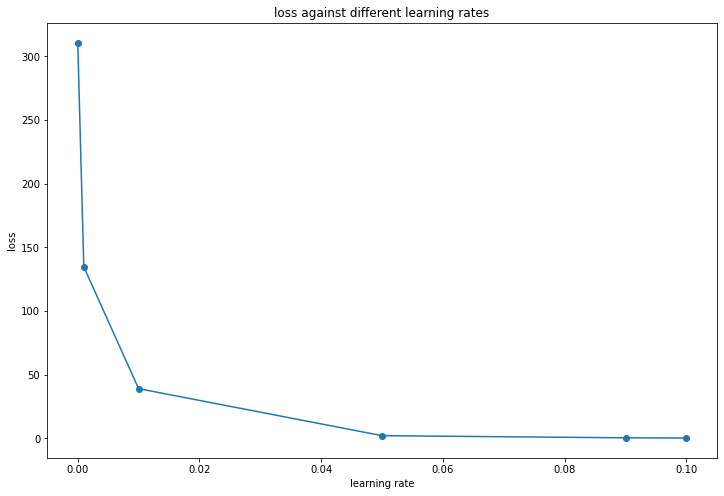

In [15]:
# plot loss function against different learning rates
plt.figure(figsize=(12,8))
plt.plot(learning_rates, final_score,marker="o")
plt.title("loss against different learning rates")
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.show()

It is observed from the plot that as the learning rate increases, the loss becomes smaller and the loss decreases more slowly.\
This may be due to the fact that the learning rate is too small for the MLP to converge to the optimal solution in 40 epochs. \
In this case choosing a larger learning rate helps the model to find a better solution within a given number of iterations.

1.1.2

In [16]:
def transform(y):
    y_out = np.zeros(len(y))
    for i in range(len(y_out)):
        y_out[i] = np.argmax(y[i])
    return y_out

In [17]:
optimal_learning_rate_index = np.argmin(final_score)
optimal_learning_rate = learning_rates[optimal_learning_rate_index]

In [32]:
def mlp_plot(hidden_sizes):
    """
    this function return the loss scores and accuracy scores against several epochs
    """
    input_size = 784
    output_size = 10
    num_hidden_layers = len(hidden_sizes)
    num_epochs = 40
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    batch_size = 128
    num_batches = train_x.shape[0] // batch_size
    num_epochs = 40
    learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    score_old = 0
    weights = [np.random.randn(input_size, hidden_sizes[0])* np.sqrt(2. / (input_size + hidden_sizes[0]))]
    biases = [np.zeros((hidden_sizes[0],))]
    for i in range(num_hidden_layers - 1):
        weights.append(np.random.randn(hidden_sizes[i], hidden_sizes[i+1])*np.sqrt(2. / (hidden_sizes[i] + hidden_sizes[i+1])))
        biases.append(np.zeros((hidden_sizes[i+1],)))
    weights.append(np.random.randn(hidden_sizes[-1], output_size)*np.sqrt(2. / (hidden_sizes[-1] + output_size)))
    biases.append(np.zeros((output_size,)))
    for epoch in range(num_epochs):

        for batch in range(num_batches):
                # Extract a batch of data
            batch_x = train_x[batch*batch_size : (batch+1)*batch_size]
            batch_y = train_y[batch*batch_size : (batch+1)*batch_size]


                # Forward pass
            a1 = dense(batch_x, weights[0], biases[0])
            h1 = softplus(a1)
            a2 = dense(h1, weights[1], biases[1])
            h2 = softplus(a2)
            a3 = dense(h2, weights[2], biases[2])
            h3 = softplus(a3)
            a4 = dense(h3, weights[3], biases[3])
            h4 = softmax(a4)

                # Backward pass
            delta4 = error(batch_y, h4)
            delta3 = backpropagate(delta4, weights[3], a3)
            delta2 = backpropagate(delta3, weights[2], a2)
            delta1 = backpropagate(delta2, weights[1], a1)

                # Update weights and biases
            weights[3] -= optimal_learning_rate * (np.mean(delta4[:, np.newaxis, :] * h3[:, :, np.newaxis],axis=0))
            biases[3] -= optimal_learning_rate * np.mean(delta4,axis=0)
            weights[2] -= optimal_learning_rate * (np.mean(delta3[:, np.newaxis, :] * h2[:, :, np.newaxis],axis=0)) 
            biases[2] -= optimal_learning_rate * np.mean(delta3,axis=0)
            weights[1] -= optimal_learning_rate * (np.mean(delta2[:, np.newaxis, :] * h1[:, :, np.newaxis],axis=0))
            biases[1] -= optimal_learning_rate * np.mean(delta2,axis=0)
            weights[0] -= optimal_learning_rate * (np.mean(delta1[:, np.newaxis, :] * batch_x[:, :, np.newaxis],axis=0))
            biases[0] -= optimal_learning_rate * np.mean(delta1,axis=0)

        a1_tr = dense(train_x, weights[0], biases[0])
        h1_tr = softplus(a1_tr)
        a2_tr = dense(h1_tr, weights[1], biases[1])
        h2_tr = softplus(a2_tr)
        a3_tr = dense(h2_tr, weights[2], biases[2])
        h3_tr = softplus(a3_tr)
        a4_tr = dense(h3_tr, weights[3], biases[3])
        h4_tr = softmax(a4_tr)

        a1_te = dense(test_x, weights[0], biases[0])
        h1_te = softplus(a1_te)
        a2_te = dense(h1_te, weights[1], biases[1])
        h2_te = softplus(a2_te)
        a3_te = dense(h2_te, weights[2], biases[2])
        h3_te = softplus(a3_te)
        a4_te = dense(h3_te, weights[3], biases[3])
        h4_te = softmax(a4_te)

        train_losses.append(kl_divergence(train_y, h4_tr))
        train_accuracies.append(np.mean(train_yy == transform(h4_tr)))

        test_losses.append(kl_divergence(test_y, h4_te))
        test_accuracies.append(np.mean(test_yy == transform(h4_te)))
    return train_losses, train_accuracies, test_losses, test_accuracies

In [33]:
hidden_sizes = [200, 200, 200]
num_epochs = 40
train_losses, train_accuracies, test_losses, test_accuracies = mlp_plot(hidden_sizes)

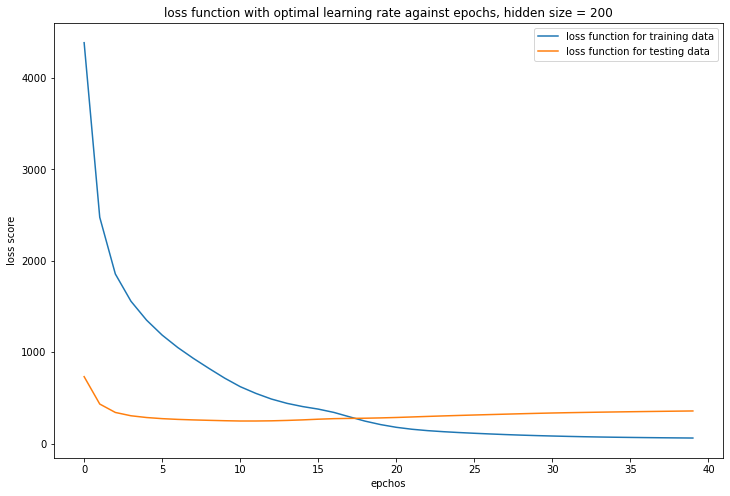

In [34]:
#loss score with optimal learning rate against epochs
num_epochs = 40
plt.figure(figsize=(12,8))
plt.plot(np.arange(num_epochs),train_losses,label="loss function for training data")
plt.plot(np.arange(num_epochs),test_losses,label="loss function for testing data")
plt.xlabel("epchos")
plt.ylabel("loss score")
plt.title("loss function with optimal learning rate against epochs, hidden size = 200")
plt.legend()
plt.show()

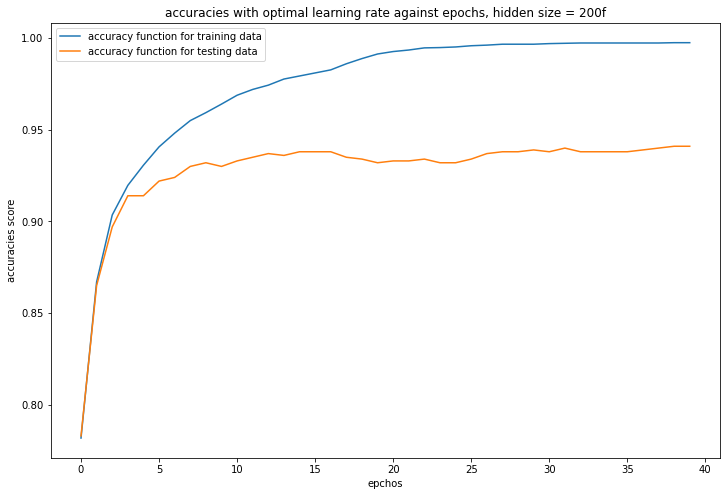

In [35]:
#accuracy score with optimal learning rate against epochs
plt.figure(figsize=(12,8))
plt.plot(np.arange(num_epochs),train_accuracies,label="accuracy function for training data")
plt.plot(np.arange(num_epochs),test_accuracies,label="accuracy function for testing data")
plt.xlabel("epchos")
plt.ylabel("accuracies score")
plt.title("accuracies with optimal learning rate against epochs, hidden size = 200f")
plt.legend()
plt.show()

1.1.3

In [36]:
hidden_sizes = [50, 50, 50]
train_losses_50, train_accuracies_50, test_losses_50, test_accuracies_50 = mlp_plot(hidden_sizes)

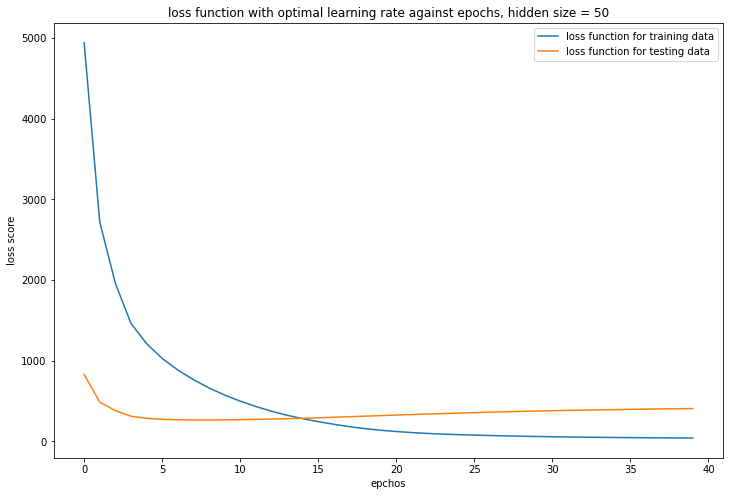

In [37]:
#loss score with optimal learning rate against epochs
#hidden size varied
plt.figure(figsize=(12,8))
plt.plot(np.arange(num_epochs),train_losses_50,label="loss function for training data")
plt.plot(np.arange(num_epochs),test_losses_50,label="loss function for testing data")
plt.xlabel("epchos")
plt.ylabel("loss score")
plt.title("loss function with optimal learning rate against epochs, hidden size = 50")
plt.legend()
plt.show()

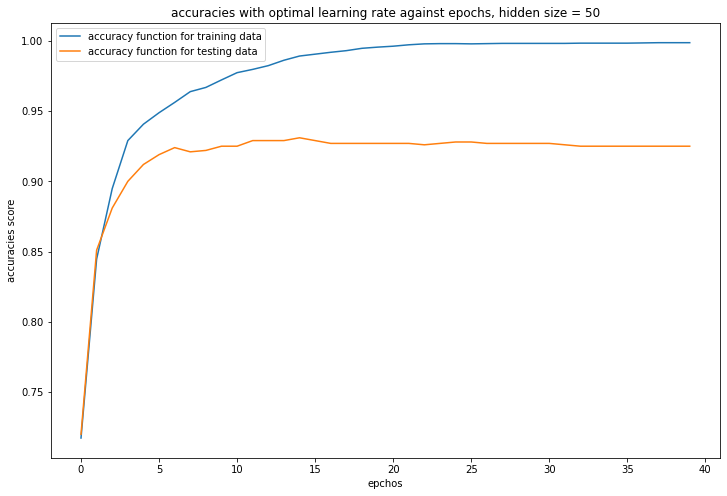

In [38]:
#accuracy score with optimal learning rate against epochs
#hidden size varied
plt.figure(figsize=(12,8))
plt.plot(np.arange(num_epochs),train_accuracies_50,label="accuracy function for training data")
plt.plot(np.arange(num_epochs),test_accuracies_50,label="accuracy function for testing data")
plt.xlabel("epchos")
plt.ylabel("accuracies score")
plt.title("accuracies with optimal learning rate against epochs, hidden size = 50")
plt.legend()
plt.show()

MLP has a higher accuracy score for training dataset than that for testing data.

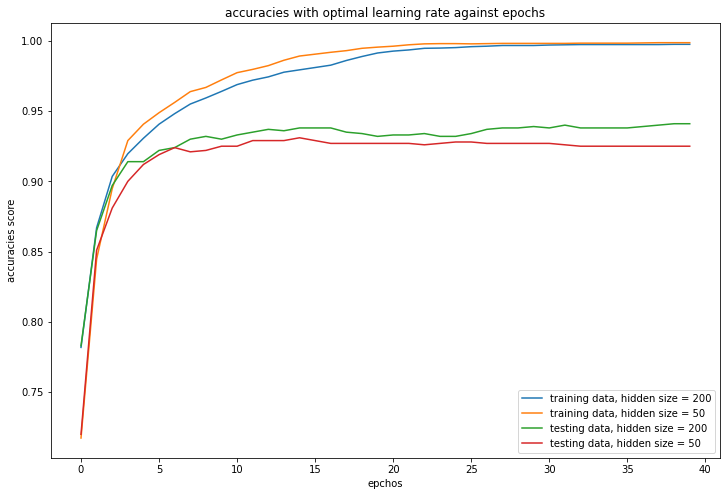

In [40]:
#accuracy score with optimal learning rate against epochs
plt.figure(figsize=(12,8))
plt.plot(np.arange(num_epochs),train_accuracies,label="training data, hidden size = 200")
plt.plot(np.arange(num_epochs),train_accuracies_50,label="training data, hidden size = 50")
plt.plot(np.arange(num_epochs),test_accuracies,label="testing data, hidden size = 200")
plt.plot(np.arange(num_epochs),test_accuracies_50,label="testing data, hidden size = 50")
plt.xlabel("epchos")
plt.ylabel("accuracies score")
plt.title("accuracies with optimal learning rate against epochs")
plt.legend()
plt.show()

I observed that for the first few epochs, the MLP in task 1.1.2 achieved higher accuracy than the MLP in task 1.1.3, but as the epoch increased the accuracy of the MLP in task 1.1.3 increased faster than the MLP in task 1.1.2. Eventually, both obtained similar accuracy on the training set. \
\
On the test set, the MLP in task 1.1.2 consistently has higher accuracy. The possible reason is that the learning rate used is large, so the MLP weights in task 1.1.2 are updated too drastically on the training set, causing the training process to become unstable and reducing the performance of accuracy in some intermediate epochs. \
\
But overall, the MLP in task 1.1.3 was underfitted because of the smaller number of neurons, resulting in consistently better performance of the MLP in task 1.1.2 on the test set.

1.1.4

In [30]:
def dropout(x, dropout_rate=0.2):
    """
    dropout function that will be applied at each hidden layer with dropout rate=0.2
    """
    dropout_mask = (np.random.rand(*x.shape) > dropout_rate).astype(float)
    dropout_mask /= (1 - dropout_rate)
    return x * dropout_mask

In [31]:
hidden_sizes = [200, 200, 200]

In [59]:
def mlp_plot(hidden_sizes, dropout_rate=0.2):
    input_size = 784
    output_size = 10
    num_hidden_layers = len(hidden_sizes)
    num_epochs = 40
    batch_size = 128
    num_batches = train_x.shape[0] // batch_size
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    weights = [np.random.randn(input_size, hidden_sizes[0])* np.sqrt(2. / (input_size + hidden_sizes[0]))]
    biases = [np.zeros((hidden_sizes[0],))]
    for i in range(num_hidden_layers - 1):
        weights.append(np.random.randn(hidden_sizes[i], hidden_sizes[i+1])*np.sqrt(2. / (hidden_sizes[i] + hidden_sizes[i+1])))
        biases.append(np.zeros((hidden_sizes[i+1],)))
    weights.append(np.random.randn(hidden_sizes[-1], output_size)*np.sqrt(2. / (hidden_sizes[-1] + output_size)))
    biases.append(np.zeros((output_size,)))
    
    for epoch in range(num_epochs):

        for batch in range(num_batches):
            # Extract a batch of data
            batch_x = train_x[batch*batch_size : (batch+1)*batch_size]
            batch_y = train_y[batch*batch_size : (batch+1)*batch_size]

            # Forward pass
            a1 = dense(batch_x, weights[0], biases[0])
            h1 = softplus(a1)
            # Apply dropout to the first hidden layer
            h1 = dropout(h1, dropout_rate)  
            a2 = dense(h1, weights[1], biases[1])
            h2 = softplus(a2)
            # Apply dropout to the second hidden layer
            h2 = dropout(h2, dropout_rate)  
            a3 = dense(h2, weights[2], biases[2])
            h3 = softplus(a3)
            # Apply dropout to the third hidden layer
            h3 = dropout(h3, dropout_rate)  
            a4 = dense(h3, weights[3], biases[3])
            h4 = softmax(a4)

            # Backward pass
            delta4 = error(batch_y, h4)
            delta3 = backpropagate(delta4, weights[3], a3)
            delta2 = backpropagate(delta3, weights[2], a2)
            delta1 = backpropagate(delta2, weights[1], a1)

            # Update weights and biases
            weights[3] -= optimal_learning_rate * (np.mean(delta4[:, np.newaxis, :] * h3[:, :, np.newaxis],axis=0))
            biases[3] -= optimal_learning_rate * np.mean(delta4,axis=0)
            weights[2] -= optimal_learning_rate * (np.mean(delta3[:, np.newaxis, :] * h2[:, :, np.newaxis],axis=0)) 
            biases[2] -= optimal_learning_rate * np.mean(delta3,axis=0)
            weights[1] -= optimal_learning_rate * (np.mean(delta2[:, np.newaxis, :] * h1[:, :, np.newaxis],axis=0))
            biases[1] -= optimal_learning_rate * np.mean(delta2,axis=0)
            weights[0] -= optimal_learning_rate * (np.mean(delta1[:, np.newaxis, :] * batch_x[:, :, np.newaxis],axis=0))
            biases[0] -= optimal_learning_rate * np.mean(delta1,axis=0)

        a1_tr = dense(train_x, weights[0], biases[0])
        h1_tr = softplus(a1_tr)
        a2_tr = dense(h1_tr, weights[1], biases[1])
        h2_tr = softplus(a2_tr)
        a3_tr = dense(h2_tr, weights[2], biases[2])
        h3_tr = softplus(a3_tr)
        a4_tr = dense(h3_tr, weights[3], biases[3])
        h4_tr = softmax(a4_tr)

        a1_te = dense(test_x, weights[0], biases[0])
        h1_te = softplus(a1_te)
        a2_te = dense(h1_te, weights[1], biases[1])
        h2_te = softplus(a2_te)
        a3_te = dense(h2_te, weights[2], biases[2])
        h3_te = softplus(a3_te)
        a4_te = dense(h3_te, weights[3], biases[3])
        h4_te = softmax(a4_te)

        train_losses.append(kl_divergence(train_y, h4_tr))
        train_accuracies.append(np.mean(train_yy == transform(h4_tr)))

        test_losses.append(kl_divergence(test_y, h4_te))
        test_accuracies.append(np.mean(test_yy == transform(h4_te)))
    return train_losses, train_accuracies, test_losses, test_accuracies, weights, biases

In [60]:
train_losses, train_accuracies, test_losses, test_accuracies, weights, biases = mlp_plot(hidden_sizes)

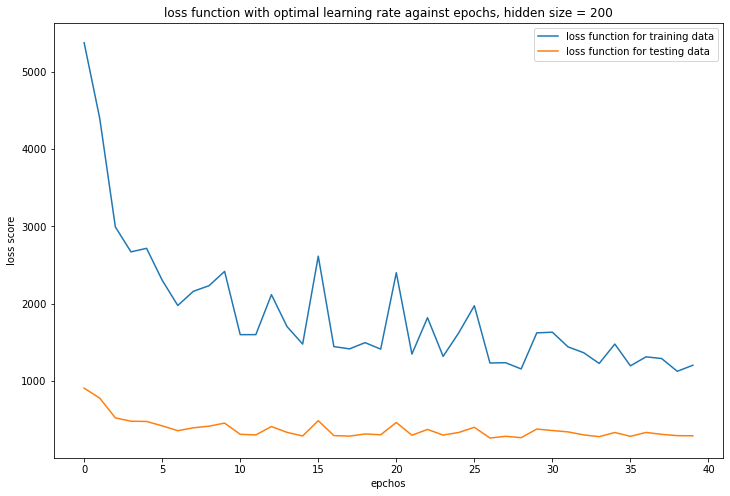

In [61]:
#loss score with optimal learning rate against epochs
#dropout applied
plt.figure(figsize=(12,8))
plt.plot(np.arange(num_epochs),train_losses,label="loss function for training data")
plt.plot(np.arange(num_epochs),test_losses,label="loss function for testing data")
plt.xlabel("epchos")
plt.ylabel("loss score")
plt.title("loss function with optimal learning rate against epochs, hidden size = 200")
plt.legend()
plt.show()

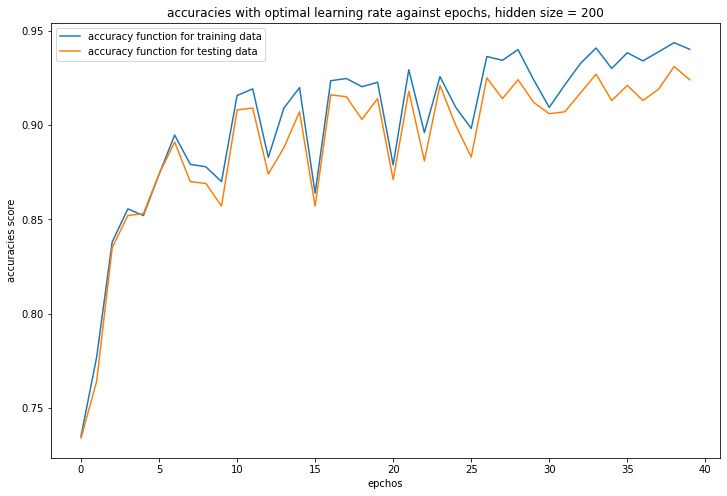

In [62]:
#accuracy score with optimal learning rate against epochs
#dropout applied
plt.figure(figsize=(12,8))
plt.plot(np.arange(num_epochs),train_accuracies,label="accuracy function for training data")
plt.plot(np.arange(num_epochs),test_accuracies,label="accuracy function for testing data")
plt.xlabel("epchos")
plt.ylabel("accuracies score")
plt.title("accuracies with optimal learning rate against epochs, hidden size = 200")
plt.legend()
plt.show()

In [63]:
# Produce histograms of the activations of the units in the first hidden layer
def get_first_hidden_layer_activations(x, weights, biases):
    a1 = dense(x, weights[0], biases[0])
    h1 = softplus(a1)
    return h1

In [64]:
# Choose a batch of test data
test_batch_x = test_x[:128]

# Get the activations for the network without dropout
activations_without_dropout = get_first_hidden_layer_activations(test_batch_x, weights, biases)

# Get the activations for the network with dropout
activations_with_dropout = dropout(activations_without_dropout)

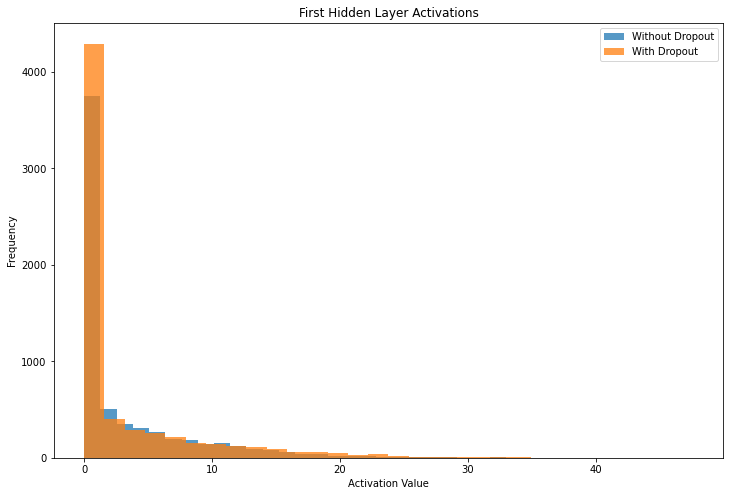

In [65]:
plt.figure(figsize=(12,8))
plt.hist(activations_without_dropout.flatten(), bins=30, alpha=0.75, label='Without Dropout')
plt.hist(activations_with_dropout.flatten(), bins=30, alpha=0.75, label='With Dropout')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.title('First Hidden Layer Activations')
plt.legend()
plt.show()

After applying dropout, the first bin of the histogram has more values because some of the activation values are set to 0. \
\
From the extreme value perspective, the maximum value of activation values becomes smaller after applying dropout because using dropout makes the MLP less dependent on individual neurons, thus making the model more generalizable. \
\
After applying dropout, the performance of the model is more unstable when the epoch increases, because dropout may randomly remove some important neurons, leading to an increase in error.

#### 1.2 Dimensionality reduction (20 marks)

1.2.1

In [66]:
# Compute the covariance matrix
covariance_matrix = np.dot(train_noisy_norm.T, train_noisy_norm) / train_noisy_norm.shape[0]

# Compute the eigenvectors and eigenvalues
eig_vals, eig_vecs = np.linalg.eigh(covariance_matrix)

# Sort the eigenvalues and eigenvectors in descending order
idx = np.argsort(eig_vals)[::-1]
eig_vals_sorted = eig_vals[idx]
eig_vecs_sorted = eig_vecs[:,idx]

# Compute the fraction of variance explained by each principal component
explained_variance_ratio = eig_vals_sorted / eig_vals_sorted.sum()
frac_var = np.cumsum(explained_variance_ratio)

# Determine the number of principal components required to explain 70%, 80%, and 90% of the variance
m70 = np.argmax(frac_var >= 0.7) + 1
m80 = np.argmax(frac_var >= 0.8) + 1
m90 = np.argmax(frac_var >= 0.9) + 1

print("Number of principal components required to explain 70% of the variance:", m70)
print("Number of principal components required to explain 80% of the variance:", m80)
print("Number of principal components required to explain 90% of the variance:", m90)

Number of principal components required to explain 70% of the variance: 213
Number of principal components required to explain 80% of the variance: 298
Number of principal components required to explain 90% of the variance: 408


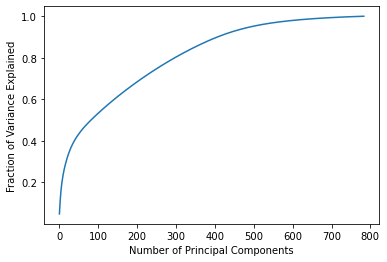

In [67]:
# Visualize the fraction of variance explained as m is increased
plt.plot(frac_var)
plt.xlabel('Number of Principal Components')
plt.ylabel('Fraction of Variance Explained')
plt.show()

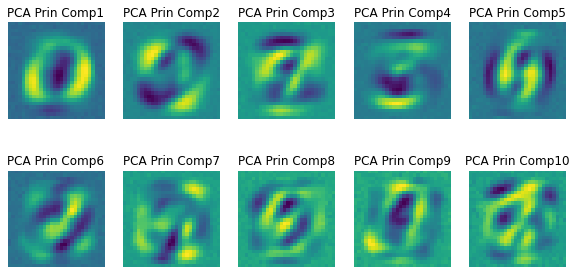

In [68]:
# Visualize the first 10 principal components
m = 10
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(eig_vecs_sorted[:, i].reshape(28, 28))
    ax.set_title(f"PCA Prin Comp{i+1}")
    ax.axis("off")
plt.show()

1.2.2

In [69]:
def cost(X,W,H):
  
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H)

    chi2 = ((X*diff) * diff).sum() / (X.shape[0]*X.shape[1])
    
    return chi2

In [70]:
def NMF(X, m, n_iters=500):
    
    # k x P matrix interpreted as the basis set, where k is the number of components, P the number of descriptors of the data
    H = np.random.rand(m, X.shape[1])

    # N x k components matrix, usually interpreted as the coefficients, N is the number of data
    W = np.random.rand(X.shape[0], m)
    
    pseudo_count = 0.001 ## this is just a small value that we place at the denominator to avoid division by zero

    # empty list 
    cost_values = []

    # loop over the n iterations
    for i in range(n_iters):

        # compute the update on H
        H = H * ((W.T.dot(X))/(W.T.dot(W.dot(H))+pseudo_count)) ## <-- SOLUTION

        # compute the update on W
        W = W * ((X.dot(H.T))/(W.dot(H.dot(H.T))+pseudo_count)) ## <-- SOLUTION

        # compute the cost and append to list
        cost_values.append(cost(X,W,H))
    return W, H, cost_values

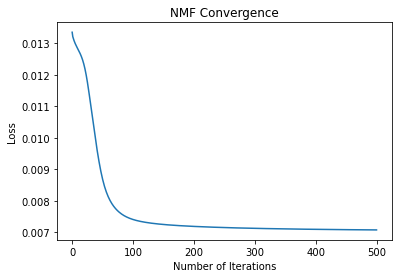

In [71]:
# Visualize the loss as the number of iteration is creased
m = 10
W, H, loss_history = NMF(train_noisy_norm_nmf, m)

plt.plot(loss_history)
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('NMF Convergence')
plt.show()

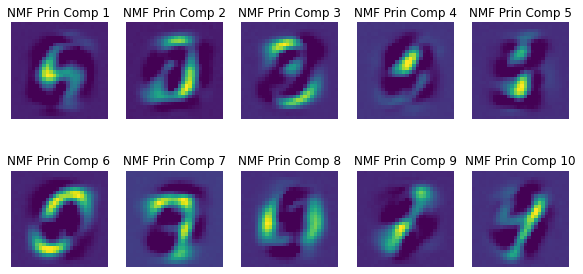

In [72]:
# Visualize the first 10 principal components
m = 10
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(H[i].reshape(28, 28))
    ax.set_title(f"NMF Prin Comp {i+1}")
    ax.axis("off")
plt.show()

The difference is because NMF expresses the data in a linear combination of components, which can be understood as different components extracted correspond to different details of the picture, while each component of PCA contains all the details.

1.2.3

In [73]:
def pca_function(X,m):

    # create covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X)

    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, m, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors)
    return X_pca, eigenvectors, eigenvalues

In [74]:
#PCA
m = 100
X_pca, pca_principal_components, eigenvalues = pca_function(train_noisy_norm, m)

# Project and reconstruct the test set images\
pca_test_noisy = np.dot(np.dot(test_noisy_norm, pca_principal_components), pca_principal_components.T)

In [75]:
#NMF
m = 100
W_train, H_train, cost_values = NMF(train_noisy_norm_nmf.T, m)

H_test = np.zeros((m, test_noisy_norm_nmf.shape[0]))
for i in range(test_noisy_norm_nmf.shape[0]):
    H_test[:, i], cost_values = nnls(W_train, test_noisy_norm_nmf[i, :])

nmf_test_noisy = np.dot(W_train, H_test).T

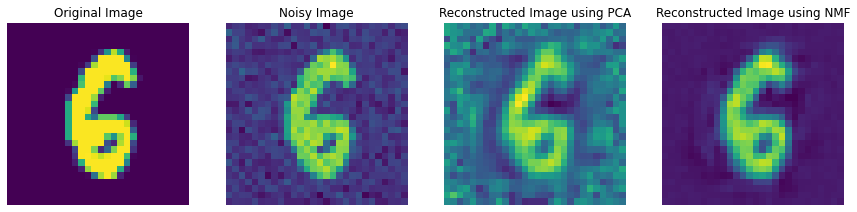

In [76]:
image_index = 1

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(test_norm_nmf[image_index].reshape(28, 28))
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(test_noisy_norm_nmf[image_index].reshape(28, 28))
axes[1].set_title("Noisy Image")
axes[1].axis("off")

axes[2].imshow(pca_test_noisy[image_index].reshape(28, 28))
axes[2].set_title("Reconstructed Image using PCA")
axes[2].axis("off")

axes[3].imshow(nmf_test_noisy[image_index].reshape(28, 28))
axes[3].set_title("Reconstructed Image using NMF")
axes[3].axis("off")

plt.show()

Both PCA and NMF can reconstruct the image with relatively high interpretability: we can recognise the pattern from reconstructed inage.\
From the images shown, the reconstructed image using PCA Reconstruction have relatively higher error compared with the one using NMF.

1.2.4

In [77]:
def MSE(true, pred):
    return np.mean((true - pred) ** 2)

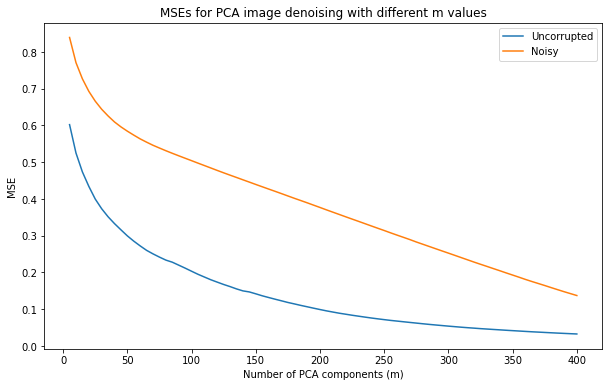

In [78]:
m_values = range(5, 401, 5)

MSE_un = []
MSE_noisy = []

for m in m_values:
    # the test set of uncorrupted images
    X_pca_un, pca_principal_components_un, eigenvalues_un = pca_function(train_norm, m)
    pca_test_un = np.dot(np.dot(test_norm, pca_principal_components_un), pca_principal_components_un.T)
    mse_un = MSE(test_norm, pca_test_un)
    MSE_un.append(mse_un)
    
    # the test set of noise-corrupted images
    X_pca_noisy, pca_principal_components_noisy, eigenvalues_noisy = pca_function(train_noisy_norm, m)
    pca_test_noisy = np.dot(np.dot(test_noisy_norm, pca_principal_components_noisy), pca_principal_components_noisy.T)
    mse_noisy = MSE(test_noisy_norm, pca_test_noisy)
    MSE_noisy.append(mse_noisy)

plt.figure(figsize=(10, 6))
plt.plot(m_values, MSE_un, label="Uncorrupted")
plt.plot(m_values, MSE_noisy, label="Noisy")
plt.xlabel("Number of PCA components (m)")
plt.ylabel("MSE")
plt.legend()
plt.title("MSEs for PCA image denoising with different m values")
plt.show()

(-0.5, 27.5, 27.5, -0.5)

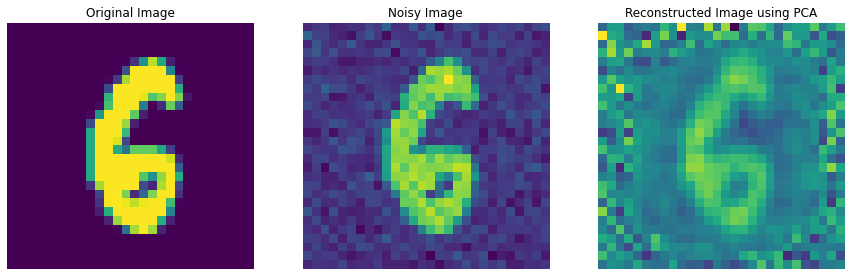

In [79]:
image_index = 1
m_values_illustration = [10, 40, 100, 200]

m = 10
X_pca, pca_principal_components, eigenvalues = pca_function(train_noisy_norm, m)
pca_test_noisy10 = np.dot(np.dot(test_noisy_norm, pca_principal_components), pca_principal_components.T)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(test_norm_nmf[image_index].reshape(28, 28))
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(test_noisy_norm_nmf[image_index].reshape(28, 28))
axes[1].set_title("Noisy Image")
axes[1].axis("off")

axes[2].imshow(pca_test_noisy[image_index].reshape(28, 28))
axes[2].set_title("Reconstructed Image using PCA")
axes[2].axis("off")

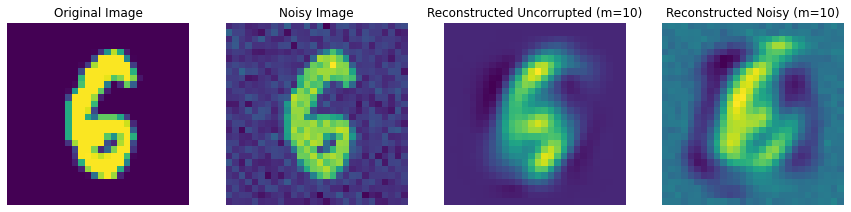

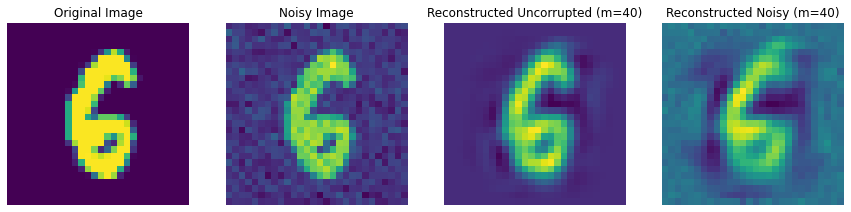

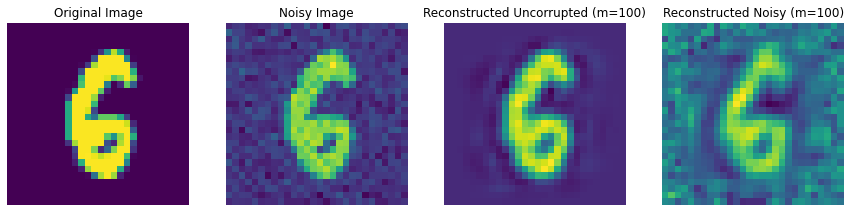

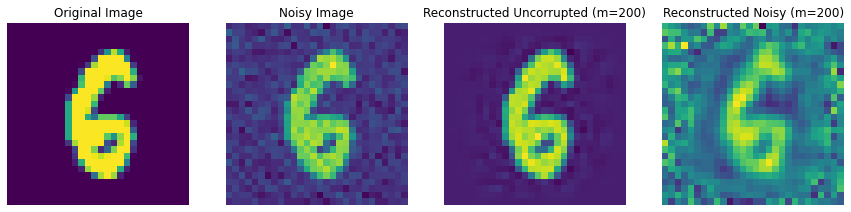

In [80]:
image_idx = 1

m_values_illustration = [10, 40, 100, 200]

for m in m_values_illustration:
    X_pca_un, pca_principal_components_un, eigenvalues_un = pca_function(train_norm_nmf, m)
    pca_test_un = np.dot(np.dot(test_norm_nmf, pca_principal_components_un), pca_principal_components_un.T)
    
    X_pca_noisy, pca_principal_components_noisy, eigenvalues_noisy = pca_function(train_noisy_norm, m)
    pca_test_noisy = np.dot(np.dot(test_noisy_norm, pca_principal_components_noisy), pca_principal_components_noisy.T)
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    axes[0].imshow(test_norm_nmf[image_index].reshape(28, 28))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(test_noisy_norm_nmf[image_index].reshape(28, 28))
    axes[1].set_title("Noisy Image")
    axes[1].axis("off")

    axes[2].imshow(pca_test_un[image_index].reshape(28, 28))
    axes[2].set_title(f"Reconstructed Uncorrupted (m={m})")
    axes[2].axis("off")
    
    axes[3].imshow(pca_test_noisy[image_index].reshape(28, 28))
    axes[3].set_title(f"Reconstructed Noisy (m={m})")
    axes[3].axis("off")
    plt.show()

I notice that the MSE score for the noisy dataset is higher than that for the uncorrupted dataset for all values of m.\
\
This indicates that the noise in the images has a significant impact on the accuracy of the reconstructed images.\
This is expected since the noise is a form of random variation that cannot be predicted or modeled.\
Therefore, the reconstructed images will always have some level of error due to the noise, which leads to a higher MSE score.\
\
The difference between the two MSE scores also reflects the effectiveness of the PCA algorithm in denoising the images.\
The larger the difference between the two MSE scores, the more effective the algorithm is in removing the noise from the images.\
\
It's important to note that even though the MSE score for the noisy dataset is higher than the uncorrupted dataset, the reconstructed images can still be useful for some applications, such as image recognition or classification.

#### 1.3 Gaussian Mixture Models (20 marks)
1.3.1

In [81]:
def standardise(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

In [82]:
X = standardise(train.iloc[:1000,1:].values)
y = train.iloc[:1000, 0].values

In [83]:
def cluster_probabilities(gmm, X):
    """Predicts probability of each data point with respect to each cluster"""
    
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # Creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i]) ### <- fill in
        likelihood[:,i] = distribution.pdf(X) 

        numerator = likelihood * gmm.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
    return weights

In [84]:
def predict(gmm, X):
    """Performs hard clustering"""
    weights = cluster_probabilities(gmm,X)
    return np.argmax(weights, axis=1)

In [85]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s[0]), 2 * np.sqrt(s[1])
    else:
        angle = 0
        width, height = 2 * np.sqrt(np.diag(covariance)[:2])
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle=angle, **kwargs))

        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = predict(gmm,X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights.max()
    for pos, covar, w in zip(gmm.mu, gmm.sigma, gmm.phi):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    return ax

In [86]:
def fitStep(gmm,X):
    """Performs an EM step by updating all parameters"""
    
    # E-Step: update weights and phi holding mu and sigma constant
    weights = cluster_probabilities(gmm,X) ### <- fill in
    gmm.phi = weights.mean(axis=0)
        
    # M-Step: update mu and sigma holding pi and weights constant
    for i in range(gmm.dim):
        weight = weights[:, [i]]
        total_weight = weight.sum()

        gmm.mu[i] = (X * weight).sum(axis=0) / total_weight 
        gmm.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)

In [87]:
class GMModel:
    def __init__(self, X, dim):
        """Initialises parameters through random split of the data"""
        self.dim = dim
        n, m = X.shape
        # initial weights given to each cluster are stored in phi or P(Ci=j)
        self.phi = np.full(shape=self.dim, fill_value=1/self.dim) 
        
        # dataset is divided randomly into k parts of unequal sizes
        random_row = np.random.randint(low=0, high=n, size=self.dim)
        
        # initial value of mean of k Gaussians
        self.mu = [  X[row_index,:] for row_index in random_row ]  
        
        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j)
        self.weights = np.full(shape=X.shape, fill_value=1/self.dim)
        
        self.means = [X[row_index, :] for row_index in random_row]
        
        # initial value of covariance matrix of k Gaussians
        self.sigma = [ np.cov(X.T) for _ in range(self.dim) ]         

    def _expectation(gmm, X):
        n_samples, _ = X.shape
        n_components = gmm.dim
        responsibilities = np.zeros((n_samples, n_components))
        for i in range(n_components):
            distribution = multivariate_normal(mean=gmm.means[i], cov=gmm.sigma[i])
            responsibilities[:, i] = gmm.phi[i] * distribution.pdf(X)
        return responsibilities

    def _maximization(self, X, responsibilities):
        weights = responsibilities.sum(axis=0)
        self.phi = weights / X.shape[0]
        self.mu = np.dot(responsibilities.T, X) / weights[:, np.newaxis]

        for i in range(self.dim):
            diff = X - self.mu[i]
            weighted_diff = diff * responsibilities[:, i, np.newaxis]
            self.sigma[i] = np.dot(weighted_diff.T, diff) / weights[i]

    def fit(self, X, max_iter=100, tol=1e-4):
        for _ in range(max_iter):
            prev_means = np.array(self.means.copy())
            responsibilities = self._expectation(X)
            self._maximization(X, responsibilities)

            if np.linalg.norm(np.array(self.means) - prev_means) < tol:
                break

    def predict(self, X):
        responsibilities = self._expectation(X)
        return np.argmax(responsibilities, axis=1)

<ipython-input-83-4f29af90c4b5>:15: RuntimeWarning: invalid value encountered in true_divide
  weights = numerator / denominator


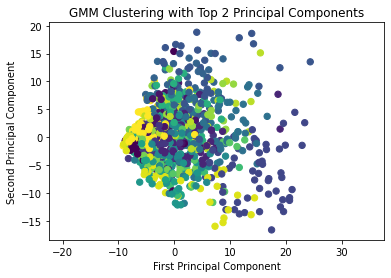

In [88]:
# Perform PCA
m = 10
pca, pca_principal_components, eigenvalues = pca_function(X, m)
X_pca = np.dot(X, pca_principal_components)

# Fit the Gaussian Mixture Model
m = 20
gmm = GMModel(X_pca, m)
gmm.fit(X_pca)

# Visualize the top 2 principal components
plot_gmm(gmm, X_pca)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('GMM Clustering with Top 2 Principal Components')
plt.show()

1.3.2

In [89]:
def plot_gmm(gmm, X, label=None, ax=None):
    ax = ax or plt.gca()
    labels = predict(gmm,X)
    if label is not None:
        ax.scatter(X[:, 0], X[:, 1], c=label, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights.max()
    for pos, covar, w in zip(gmm.mu, gmm.sigma, gmm.phi):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    return ax

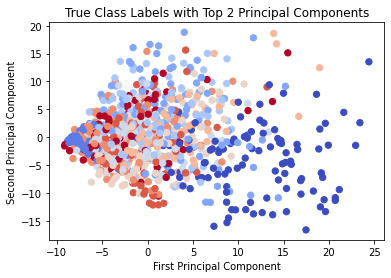

In [90]:
plt.scatter(np.real(X_pca[:, 0]), np.real(X_pca[:, 1]), c=y, s=40, cmap='coolwarm', zorder=2)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('True Class Labels with Top 2 Principal Components')
plt.show()

In [91]:
def log_likelihood(gmm, X):
    log_likelihoods = np.zeros((X.shape[0], gmm.dim))
    for i in range(gmm.dim):
        distribution = multivariate_normal(mean=gmm.mu[i], cov=gmm.sigma[i])
        log_likelihoods[:, i] = np.log(gmm.phi[i]) + distribution.logpdf(X)
    return log_likelihoods

In [92]:
log_likelihoods = log_likelihood(gmm, X_pca)

In [93]:
def average_log_likelihood_by_class(log_likelihoods, y, n_classes=10):
    avg_log_likelihoods = np.zeros((n_classes, log_likelihoods.shape[1]))
    for class_label in range(n_classes):
        class_indices = np.where(y == class_label)
        class_log_likelihoods = log_likelihoods[class_indices]
        avg_log_likelihoods[class_label] = class_log_likelihoods.mean(axis=0)
    return avg_log_likelihoods

In [94]:
avg_log_likelihoods = average_log_likelihood_by_class(log_likelihoods, y)

In [95]:
print("Best clusters for each class based on log-likelihood:", np.argmax(avg_log_likelihoods, axis=1))

Best clusters for each class based on log-likelihood: [ 4  0 16  6 17  7  2  7 12 17]


1.3.3

In [96]:
def cluster_probabilities(gmm, X):
    n_samples, m_samples = X.shape
    n_components = gmm.dim
    responsibilities = np.zeros((n_samples, n_components))
    for i in range(n_components):
        distribution = multivariate_normal(mean=gmm.mu[i], cov=gmm.sigma[i])
        responsibilities[:, i] = gmm.phi[i] * distribution.pdf(X)
    return responsibilities / responsibilities.sum(axis=1, keepdims=True)

In [97]:
cluster_probs = cluster_probabilities(gmm, X_pca)

<ipython-input-96-2b32c1842125>:8: RuntimeWarning: invalid value encountered in true_divide
  return responsibilities / responsibilities.sum(axis=1, keepdims=True)


In [98]:
def fit_quality(log_likelihoods, y, n_classes=10):
    fit_quality_scores = np.zeros((n_classes, log_likelihoods.shape[1]))
    for class_label in range(n_classes):
        class_indices = np.where(y == class_label)
        class_log_likelihoods = log_likelihoods[class_indices]
        fit_quality_scores[class_label] = class_log_likelihoods.mean(axis=0)
    return fit_quality_scores

In [99]:
fit_quality_scores = fit_quality(log_likelihoods, y)

In [100]:
def best_fitting_cluster_probs(cluster_probs, y, best_clusters):
    best_probs = np.zeros_like(y, dtype=float)
    for class_label, cluster_idx in enumerate(best_clusters):
        class_indices = np.where(y == class_label)
        best_probs[class_indices] = cluster_probs[class_indices, cluster_idx]
    return best_probs

In [101]:
best_cluster_probs = best_fitting_cluster_probs(cluster_probs, y, np.argmax(fit_quality_scores, axis=1))

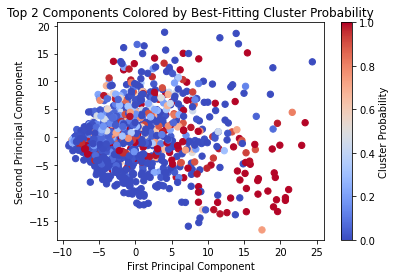

In [102]:
def plot_probs(X_pca, y, best_cluster_probs):
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_cluster_probs, s=40, cmap='coolwarm', zorder=2)
    plt.colorbar(label='Cluster Probability')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('Top 2 Components Colored by Best-Fitting Cluster Probability')
    plt.show()

plot_probs(X_pca, y, best_cluster_probs)

1.3.4

In [103]:
# fit the GMM with 5 components:
n_components_5 = 5
gmm_5 = GMModel(X_pca, n_components_5)
gmm_5.fit(X_pca)
#fit the GMM with 8 components:
n_components_8 = 8
gmm_8 = GMModel(X_pca, n_components_8)
gmm_8.fit(X_pca)

In [104]:
log_likelihoods_5 = np.log(cluster_probabilities(gmm_5, np.real(X_pca))+1e-6)
log_likelihoods_8 = np.log(cluster_probabilities(gmm_8, np.real(X_pca))+1e-6)

<ipython-input-96-2b32c1842125>:8: RuntimeWarning: invalid value encountered in true_divide
  return responsibilities / responsibilities.sum(axis=1, keepdims=True)


In [105]:
avg_log_likelihoods_5 = average_log_likelihood_by_class(log_likelihoods_5, y)
avg_log_likelihoods_8 = average_log_likelihood_by_class(log_likelihoods_8, y)

In [106]:
print("Best clusters for each class based on log-likelihood (5 components):", np.argmax(avg_log_likelihoods_5, axis=1))
print("Best clusters for each class based on log-likelihood (8 components):", np.argmax(avg_log_likelihoods_8, axis=1))

Best clusters for each class based on log-likelihood (5 components): [2 1 3 3 1 3 3 0 3 1]
Best clusters for each class based on log-likelihood (8 components): [0 3 0 0 5 0 2 0 5 5]


### Task 2: Clustering and graph-based analysis (35 marks)

In [107]:
def standardise(X):
    mu = np.mean(X, 0)
    sigma = np.std(X, 0)
    X_std = (X - mu) / sigma
    return X_std

In [108]:
data = pd.read_csv("gene_expression_data.csv")
gene_notype_df = data.drop('Type', axis=1, inplace=False)

gene_notype_df_std = standardise(gene_notype_df)

n_samples, n_features = gene_notype_df_std.shape

#### 2.1 Clustering (15 marks)
2.1.1

In [109]:
def compute_BCSM(data, labels, centroids):
    # number of clusters
    k = len(set(labels)) 
    n_samples, n_features = data.shape
    ztot = np.mean(data, axis=0) 
    
    BCSM = 0
    
    for a in range(k):
        ni = len([i for i in labels if i == a])
        BCSM += ni * np.linalg.norm(centroids[a] - ztot)**2

    return BCSM


def compute_WCSM(data, labels, centroids):
    # number of clusters
    k = len(set(labels))
    n_samples, n_features = data.shape
    
    WCSM = 0
    
    for a in range(k):
        WCSM += np.sum(np.linalg.norm((data[labels == a] - centroids[a]), axis=1)**2)
    
    return WCSM


def compute_CH(data, labels, centroids):
    # number of clusters
    k = len(set(labels)) 
    # number of data points
    n_samples, n_features = data.shape
    
    # Compute BCSM
    BCSM = compute_BCSM(data, labels, centroids)
    # Compute WCSM
    WCSM = compute_WCSM(data, labels, centroids)
    
    # Compute CH index
    CH = (BCSM*(n_samples-k)) / ((k-1)*WCSM)
    return CH

In [110]:
def compute_k(X, k, max_iter=30):
    """
    for one certain k, 
    first get the best clusterings through iterations,
    then compute the CH score for this clustering
    """
    
    n_samples, n_features = X.shape
    # initialize centroids randomly for each initialization
    labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)
    total_score = 0

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:n_features]
        
    new_labels = np.zeros(len(X))

    # k-means algorithm
    for i in range(max_iter):
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)
        
        # if labels are unchanged
        # terminate iteration as datas are all assigned to 'appropriate' clusters
        if (labels==new_labels).all():
            labels = new_labels
            break
            
        # if labels are changed
        else:
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)
                    
     # Evaluate clustering using CH index
    score = compute_CH(X, labels, centroids)
    
    best_centroids = centroids
    best_labels = labels

    return best_labels, best_centroids, score

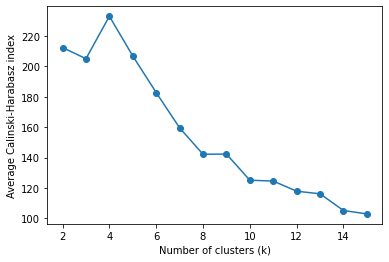

In [111]:
# test k-means for different values of k
k_values = range(2, 16)
k_scores = []
all_scores = []

for k in k_values:
    k_scores = []
    # test 5 initializations per k
    for i in range(5):
        best_labels, best_centroids, score = compute_k(gene_notype_df_std, k)
        k_scores.append(score)
    avg_score = np.mean(k_scores)
    all_scores.append(avg_score)

# Plot average CH index scores for different values of k
plt.plot(k_values, all_scores, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Calinski-Harabasz index')
plt.show()

In [112]:
#report the size of the clusters found by k-means with the optimal k
optimal_k_index = np.argmax(all_scores)
optimal_k = k_values[optimal_k_index]
print("the size of clusters found by k-means with the optimal k is", optimal_k)

the size of clusters found by k-means with the optimal k is 4


2.1.2

In [119]:
data = pd.read_csv("gene_expression_data.csv")

#replace the str with numerical values
data['Type'] = data['Type'].replace({'BRCA': 0, 'KIRC': 1, 'COAD': 2, 'LUAD': 3, 'PRAD': 4})
gene_type = data['Type']

gene_all = data
n_samples_all, n_features_all = gene_all.shape
N = n_samples_all
best_labels, best_centroids, score = compute_k(gene_notype_df_std, optimal_k)

#C is the number of distinct types/classes
#this should always be 5
C = len(np.unique(gene_type))

#K is the number of distinct clusters/labels
#this should be the same as optimal_k
K = len(np.unique(best_labels))

In [120]:
def aCK(data, gene_type, best_labels):
    """
     this function calculate the number of data points that belong to class c and are assigned to cluster k 
    """
    n_samples_all, n_features_all = data.shape
    
    data_in_class_c = np.array([np.sum(gene_type == c) for c in range(C)])
    data_in_cluster_k = np.array([np.sum(best_labels == k) for k in range(K)])
    
    n = np.array([[np.sum(np.logical_and((best_labels == k),(gene_type == c))) for c in range(C)] for k in range(optimal_k)])
    
    return data_in_class_c, data_in_cluster_k, n

In [121]:
def compute_H_CK(data, gene_type, best_labels):
    """
    this function compute the H(C|K)
    """
    H_CK = 0
    data_in_class_c, data_in_cluster_k, n = aCK(data, gene_type, best_labels)
    for i in range(K):
        for j in range(C):
            if data_in_cluster_k[i] != 0 and n[i][j] !=0:
                H_CK -= (n[i][j]/N)*np.log(n[i][j]/data_in_cluster_k[i])
                
    return H_CK

def compute_H_C(data, gene_type, best_labels):
    """
    this function compute the H(C)
    """
    H_C = 0
    data_in_class_c, data_in_cluster_k, n = aCK(data, gene_type, best_labels)
    
    for i in range(C):
        if data_in_class_c[i] != 0:
            H_C -= (data_in_class_c[i]/N)*np.log(data_in_class_c[i]/N)
        
    return H_C

In [122]:
def compute_homogeneity(data, gene_type, best_labels):
    """
    compute the homogeneity score for a given class c and cluster k
    """
    
    H_CK = compute_H_CK(data, gene_type, best_labels)
    H_C = compute_H_C(data, gene_type, best_labels)
    
    homo_score = 1 - H_CK/H_C
    
    return homo_score

In [123]:
homogeneity = compute_homogeneity(data, gene_type, best_labels)
print("the homogeneity of the clusters is", homogeneity)
print("Since a high value indicates high homogeneity, the clusters are quite consistent with the sample tumour types.")

the homogeneity of the clusters is 0.5867971369720714
Since a high value indicates high homogeneity, the clusters are quite consistent with the sample tumour types.


#### 2.2 Graph-based analysis (20 marks)
2.2.1

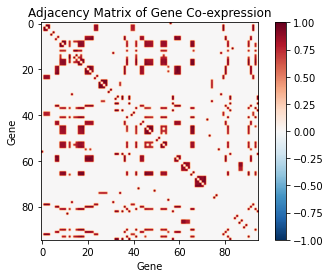

In [124]:
# compute the correlation matrix
correlation_matrix = np.corrcoef(gene_notype_df_std, rowvar=False)

# set the diagonal terms to zero
np.fill_diagonal(correlation_matrix, 0)

# perform thresholding with threshold = 0.75 on the absolute value
threshold = 0.75
correlation_matrix[np.abs(correlation_matrix) < threshold] = 0

# The thresholded correlation matrix is now the adjacency matrix of the weighted graph
adjacency_matrix = correlation_matrix

# Visualize the adjacency matrix using imshow
plt.imshow(adjacency_matrix, cmap='RdBu_r', vmin=-1, vmax=1)

# Add color bar
plt.colorbar()

# Add title and axis labels
plt.title("Adjacency Matrix of Gene Co-expression")
plt.xlabel("Gene")
plt.ylabel("Gene")

# Show the plot
plt.show()

2.2.2

In [125]:
degree_centrality = np.sum(adjacency_matrix, axis=1)

# Sort the genes in descending order of degree centrality
sorted_gene_indices = np.argsort(degree_centrality)[::-1]

top_genes = sorted_gene_indices[:5]
print("the index of the 5 top ranking genes", top_genes)

the index of the 5 top ranking genes [17 41 16 81 90]


2.2.3

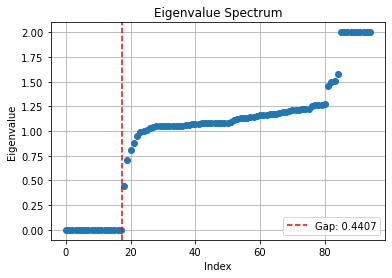

Number of zero eigenvalues: 18
it means that the algebraic connectivity of the graph is 18
This implies that the graph is disconnected into 18 connected components.
This means among all 800 features, those features can be separated into 18 groups
features in each group has similar contribution to the final determination.
And features in different groups mean they have different contributions to one biological process.


In [126]:
# Compute the degree matrix D
degree = np.sum(adjacency_matrix, axis=1)
degree_matrix = np.diag(degree)

# Compute the inverse square root of the degree matrix
degree_matrix_inv_sqrt = np.diag(1 / np.sqrt(degree))

# Compute the symmetric normalized Laplacian L
identity_matrix = np.identity(adjacency_matrix.shape[0])
Laplacian = identity_matrix - degree_matrix_inv_sqrt @ adjacency_matrix @ degree_matrix_inv_sqrt

# Compute the eigenvalues and eigenvectors of L
eigenvalues, eigenvectors = np.linalg.eigh(Laplacian)

# Plot the spectrum of eigenvalues
plt.plot(eigenvalues, marker='o', linestyle='None')
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalue Spectrum")
plt.grid()

# rounding the eigenvalues and group them into zero and non-zero values
zero_eigenvalues = eigenvalues[np.isclose(eigenvalues, 0, atol=1e-5)]
non_zero_eigenvalues = eigenvalues[~np.isclose(eigenvalues, 0, atol=1e-5)]

# Find the gap between zero and non-zero eigenvalues
gap = non_zero_eigenvalues[0] - zero_eigenvalues[-1]

# Mark the gap on the plot
plt.axvline(x=len(zero_eigenvalues) - 0.5, color='red', linestyle='--', label=f'Gap: {gap:.4f}')
plt.legend()
plt.show()

# Provide the number of zero eigenvalues
r = len(zero_eigenvalues)

print("Number of zero eigenvalues:", r)
print("it means that the algebraic connectivity of the graph is", r)
print("This implies that the graph is disconnected into", r, "connected components.")
print("This means among all 800 features, those features can be separated into",r, "groups")
print("features in each group has similar contribution to the final determination.")
print("And features in different groups mean they have different contributions to one biological process.")

2.2.4

In [127]:
def compute_k(X, k, max_iter=30):
    """
    for one certain k, 
    first get the best clusterings through iterations,
    then compute the CH score for this clustering
    """
    np.random.seed(0)
    n_samples, n_features = X.shape
    # initialize centroids randomly for each initializati
    labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)
    total_score = 0

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        for j in range(n_features):
            if X_labels[j][-1] == i:
                centroids[i][j] = np.mean(X_labels[j][0:n_features])
                #centroids[i] = np.mean([x for x in X_labels], axis=0)
        
    new_labels = np.zeros(len(X))

    # k-means algorithm
    for i in range(max_iter):
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)
        
        # if labels are unchanged
        # terminate iteration as datas are all assigned to 'appropriate' clusters
        if (labels==new_labels).all():
            labels = new_labels
            break
            
        # if labels are changed
        else:
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)
                    
     # Evaluate clustering using CH index
    score = compute_CH(X, labels, centroids)
    
    best_centroids = centroids
    best_labels = labels

    return best_labels, best_centroids, score

In [128]:
def compute_normalised_within_cluster_distance(X, labels, centroids):
    """
    Calculates the within-cluster distance for a given set of data, cluster labels, and centroids.
    """
    n_clusters = centroids.shape[0]
    distance_sum = 0
    total_sum_squares = np.sum(np.square(X - np.mean(X, axis=0)))
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        centroid = centroids[i]
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        cluster_distance = np.sum(distances)
        distance_sum += cluster_distance
    return distance_sum / total_sum_squares

<ipython-input-109-efe750d91b4e>:41: RuntimeWarning: divide by zero encountered in double_scalars
  CH = (BCSM*(n_samples-k)) / ((k-1)*WCSM)


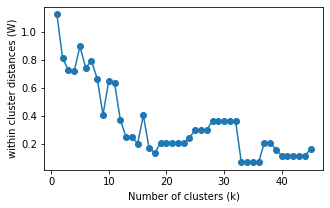

Optimal number of clusters: 9
Cluster labels: [4 6 6 6 8 8 5 5 3 3 3 0 3 1 3 3 3 3 3 5 5 5 5 6 6 2 2 2 2 0 0 1 7 7 2 7 5
 3 7 6 6 3 0 5 5 3 3 3 3 0 0 0 3 3 3 5 4 7 5 5 5 2 2 2 2 3 3 6 6 6 6 6 0 0
 2 8 8 5 1 6 5 3 7 0 4 4 2 2 0 0 3 5 6 3 7]


In [129]:
# Extract r eigenvectors corresponding to zero eigenvalues
U = eigenvectors[:, :r]

# Normalize the rows of U to form the matrix T
T = U / np.linalg.norm(U, axis=1, keepdims=True)

# Apply k-means to the matrix T while varying the value of k
# each k have 5 different initializations
max_k = 45
within_cluster_distances = []

for k in range(1, max_k + 1):
    avg_within_cluster_distance = 0
    for _ in range(5):
        labelss, centroidss,scoree = compute_k(T, k)
        within_cluster_distance = compute_normalised_within_cluster_distance(T, labelss, centroidss)
        avg_within_cluster_distance += within_cluster_distance / 5
    within_cluster_distances.append(avg_within_cluster_distance)


# Use the elbow method to find the optimal value of k
optimal_k = np.argmax(np.diff(within_cluster_distances)) + 1

# Perform k-means clustering with the optimal value of k
best_labels, best_centroids, score = compute_k(T, optimal_k)

# Plot within cluster distances for different values of k
plt.figure(figsize=(5,3))
plt.plot(range(1, max_k + 1), within_cluster_distances, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('within cluster distances (W)')
plt.show()

# Now you can analyze the labels to interpret the clusters
print("Optimal number of clusters:", optimal_k)
print("Cluster labels:", best_labels)

In [130]:
print("This clustering separate the data into", optimal_k, "clusters:")

# the clusters with the size
unique_labels, label_counts = np.unique(best_labels, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print("Cluster", label, "has size", count)
    
print("This means 95 genes can be separated into", optimal_k, "clusters.")
print("Genes in the same cluster have similar contribution to one biological process\
 and quite probably have similar biological functions")

This clustering separate the data into 9 clusters:
Cluster 0 has size 12
Cluster 1 has size 3
Cluster 2 has size 12
Cluster 3 has size 23
Cluster 4 has size 4
Cluster 5 has size 16
Cluster 6 has size 14
Cluster 7 has size 7
Cluster 8 has size 4
This means 95 genes can be separated into 9 clusters.
Genes in the same cluster have similar contribution to one biological process and quite probably have similar biological functions


2.2.5

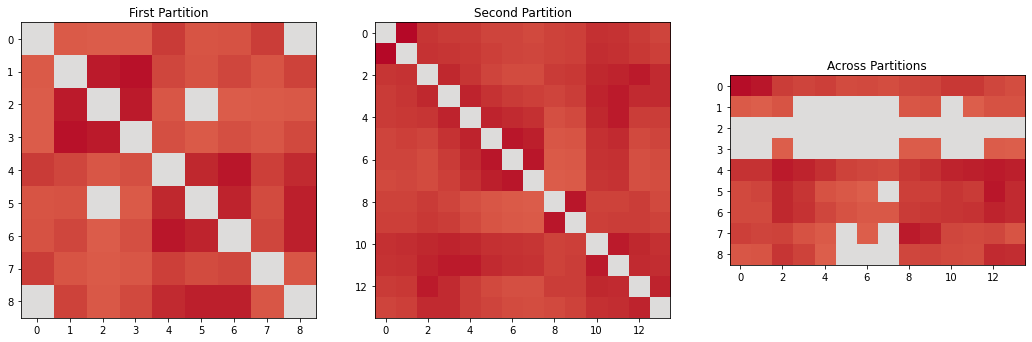

In [132]:
# get the label of largest cluster
largest_cluster_label = unique_labels[np.argmax(label_counts)]

# create a subgraph corresponding to the largest cluster
subgraph_indices = np.where(best_labels == largest_cluster_label)[0]
subgraph_adjacency = adjacency_matrix[np.ix_(subgraph_indices, subgraph_indices)]

# compute the normalized Laplacian for the subgraph
subgraph_degree = np.sum(subgraph_adjacency, axis=1)
subgraph_degree_matrix = np.diag(subgraph_degree)
subgraph_degree_matrix_inv_sqrt = np.diag(1 / np.sqrt(subgraph_degree))

subgraph_laplacian = np.identity(len(subgraph_degree)) - (subgraph_degree_matrix_inv_sqrt @ subgraph_adjacency @ subgraph_degree_matrix_inv_sqrt)

# perform spectral partitioning using the second smallest eigenvalue's eigenvector
subgraph_eigenvalues, subgraph_eigenvectors = np.linalg.eigh(subgraph_laplacian)
fiedler_vector = subgraph_eigenvectors[:, 1]

# create binary partition labels
partition_labels = np.zeros_like(fiedler_vector, dtype=int)
partition_labels[fiedler_vector > 0] = 1

#  visualize the network links within each partition and across the two partitions
# within the first partition
first_partition_indices = subgraph_indices[partition_labels == 0]
first_partition_adjacency = adjacency_matrix[np.ix_(first_partition_indices, first_partition_indices)]

# within the second partition
second_partition_indices = subgraph_indices[partition_labels == 1]
second_partition_adjacency = adjacency_matrix[np.ix_(second_partition_indices, second_partition_indices)]

# across the two partitions
across_partition_adjacency = adjacency_matrix[np.ix_(first_partition_indices, second_partition_indices)]

# plot the subgraphs
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(first_partition_adjacency, cmap='coolwarm', vmin=-1, vmax=1)
ax1.set_title("First Partition")

ax2.imshow(second_partition_adjacency, cmap='coolwarm', vmin=-1, vmax=1)
ax2.set_title("Second Partition")

ax3.imshow(across_partition_adjacency, cmap='coolwarm', vmin=-1, vmax=1)
ax3.set_title("Across Partitions")

plt.show()

The resulting plot shows three subgraphs: the network links within the first partition, the network links within the second partition, and the network links across the two partitions.\
The color of each link represents the magnitude of the link weight, with red indicating a positive weight, and blue indicating a negative weight.\
\
From the plot, we can observe that the subgraph has been divided into two partitions.\
We can see that the network links within the FIRST partition are mostly positive, indicating genes within the first partition are strongly connected.\
And the network links within the SECOND partition are mostly positive, indicating genes within the second partition are strongly connected.\
The network links ACROSS the two partitions are still mostly positive, indicating strong connections between nodes in different partitions. This suggests it is relatively difficult to further separate this cluster into two partitions. This indicates NO presence of potientially good clusters.\
\
Comparing with the plot of adjacency matrix of the total data in 2.2.1, there are much more and much stronger connections in both subgraphs.

2.2.6

In [133]:
#  compute the degree centrality of each node in the subgraph
subgraph_degree_centrality = np.sum(subgraph_adjacency, axis=1)
#  sort the nodes by their degree centrality in descending order
sorted_nodes = np.argsort(-subgraph_degree_centrality)

#  print the indices of the top 5 nodes
top_5_nodes = sorted_nodes[:5]
print("Indices of the top 5 nodes by degree centrality:", top_5_nodes)
print("Degree centrality of the top 5 nodes:", subgraph_degree_centrality[top_5_nodes])
print("Top 5 nodes centrality in 2.2.2:", degree_centrality[top_genes])

Indices of the top 5 nodes by degree centrality: [ 7 10  6 20 21]
Degree centrality of the top 5 nodes: [19.73839866 19.04945567 18.64028395 18.53179044 18.2670517 ]
Top 5 nodes centrality in 2.2.2: [19.73839866 19.04945567 18.64028395 18.53179044 18.2670517 ]


Top 5 degree centralities in the total graph (2.2.2) is the same as the top 5 degree centralities in the largest cluster.\
This means that the subgraph (this cluster with label3) is likely to have a similar structure to the full graph, with no distinct clusters or communities.\
In such a case, the degree centrality values of the nodes in the subgraph are likely to be representative of their overall importance in the full graph.